# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from PIL import Image
import datetime
import os
import cv2


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [53]:
from PIL import ImageEnhance
from PIL import ImageFilter
import random

def rand_contrast(im):
    contrast=random.random() 
    if contrast >0.8:
        enhancer = ImageEnhance.Contrast(im)
        enhanced=enhancer.enhance(contrast)
        return enhanced
    else :
        return im

def rand_brightness(im):
    brightness=random.random()
    if brightness > 0.8:
        enhancer = ImageEnhance.Brightness(im)
        enhanced=enhancer.enhance(brightness)
        return enhanced
    else :
        return im

def rand_blur(im):
    if random.random() <0.35:
        blur = im.filter(ImageFilter.GaussianBlur(radius = 5))
        return blur
    else :
        return im
def rand_crop_zoom(im):   
    width, height = im.size   # Get dimensions
    scale=random.uniform(0.9,1.0)
    new_width=int(scale*width)
    new_height=int(scale*height)
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    im = im.crop((left, top, right, bottom))
    im=im.resize((width,height),Image.Resampling.BILINEAR)
    return im

    
def generator_cv(source_path, folder_list, batch_size=16,img_size=160,seq_len=30,aug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.linspace(0,29,seq_len).astype(int)#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        #print(num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,len(img_idx),img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                #print(folder,batch,batch_size)
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                flip=0
                if aug==True:
                    if random.random() >0.5:
                        flip=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image= cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    if image.shape[0] != image.shape[1]:
                        #image=image[0:120,20:140]
                        h,w,_=image.shape
                        if h > w:
                            new_h=img_size
                            new_w=(new_h*w)//h
                        else :
                            new_w=img_size
                            new_h=(new_w*h)//w
                        image=cv2.resize(image,(new_w,new_h),cv2.INTER_LINEAR)
                        
                        
                    else :
                        image=cv2.resize(image,(img_size,img_size),cv2.INTER_LINEAR)
                    if aug==True:
                        #image=rand_contrast(image)
                        #image=rand_brightness(image)
                        #image=rand_crop_zoom(image)
                        #image=rand_blur(image)
                        if flip ==1:
                            image=cv2.flip(image, 1)
                        
                    
                    image = np.array(image).astype(np.float32)
                    h,w,_=image.shape
                    
                    #print(batch_data[folder,idx,:,:].shape)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,0:h,0:w,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,0:h,0:w,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,0:h,0:w,2] = image[:,:,2]/255#normalise and feed in the image"""
                label_idx=int(t[folder + (batch*batch_size)].strip().split(';')[2])
                
                if flip == 1 and (label_idx == 0 or  label_idx==1) :
                    #print("original label ",label_idx)
                    label_idx = 1- label_idx
                    #print("new label ",label_idx)
                batch_labels[folder, label_idx] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        leftout=len(t)-num_batches*batch_size
        covered=num_batches*batch_size
        #print("batches to be covered :",leftout,covered)
        if leftout !=0: # we iterate over the number of batches
            #batch_data = np.zeros((batch_size,len(img_idx),img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            #batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(leftout): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + covered].split(';')[0]) # read all the images in the folder
                
                flip=0
                if aug==True:
                    if random.random() >0.5:
                        flip=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image= cv2.imread(source_path+'/'+ t[folder + covered].strip().split(';')[0]+'/'+imgs[item])
                    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    if image.shape[0] != image.shape[1]:
                        #image=image[0:120,20:140]
                        h,w,_=image.shape
                        if h > w:
                            new_h=img_size
                            new_w=(new_h*w)//h
                        else :
                            new_w=img_size
                            new_h=(new_w*h)//w
                        image=cv2.resize(image,(new_w,new_h),cv2.INTER_LINEAR)
                        
                        
                    else :
                        image=cv2.resize(image,(img_size,img_size),cv2.INTER_LINEAR)
                    if aug==True:
                        #image=rand_contrast(image)
                        #image=rand_brightness(image)
                        #image=rand_crop_zoom(image)
                        #image=rand_blur(image)
                        if flip ==1:
                            image=cv2.flip(image, 1)
                        
                    
                    image = np.array(image).astype(np.float32)
                    h,w,_=image.shape
                    
                    #print(batch_data[folder,idx,:,:].shape)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,0:h,0:w,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,0:h,0:w,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,0:h,0:w,2] = image[:,:,2]/255#normalise and feed in the image"""
                label_idx=int(t[folder + (batch*batch_size)].strip().split(';')[2])
                
                if flip == 1 and (label_idx == 0 or  label_idx==1) :
                    #print("original label ",label_idx)
                    label_idx = 1- label_idx
                    #print("new label ",label_idx)
                batch_labels[folder, label_idx] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [44]:
t=generator_cv(train_path, train_doc,seq_len=30,img_size=120,aug=True,batch_size=32 )

Source path =  ./Project_data/train ; batch size = 32


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [27]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [22]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM,Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Input,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D ,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here


In [7]:
def SimpleConvBlock(filters,input,name,seq_kernel=3,batch_norm=True):
    conv_1=Conv3D(filters,(seq_kernel,3,3),activation='relu',padding='same',name=name+'_0')(input)
    print('batch_norm ',batch_norm)
    if batch_norm ==True:
        conv_1=BatchNormalization()(conv_1)   
    pool=MaxPooling3D((2,2,2),name=name+'_pool')(conv_1)
    #dropout=Dropout(0.2)(pool)
    return pool

In [8]:
def Conv3DModel(seq_len,img_size,bn=True,dropout=True):
    X=Input([seq_len,img_size,img_size,3],name="input")
    conv1=SimpleConvBlock(8,X,'Conv_1',batch_norm=bn)
    conv2=SimpleConvBlock(16,conv1,'Conv_2',batch_norm=bn)
    conv3=SimpleConvBlock(32,conv2,'Conv_3',batch_norm=bn)
    conv4=SimpleConvBlock(64,conv3,'Conv_4',batch_norm=bn)
    print("bn ",bn)
    
    flatten=Flatten()(conv4)
    
    
    class_1=Dense(256,activation='relu',name="Class_1")(flatten)
    if dropout == True:
        class_1=Dropout(0.5)(class_1)
    
    class_2=Dense(128,activation='relu',name="Class_2")(class_1)
    if dropout == True:
        class_2=Dropout(0.25)(class_2)
    
    class_3=Dense(5,activation='softmax',name="output")(class_2)
    Y=class_3

    model=Model(X,Y) 
    return model

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000005
)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
def get_train_validation_steps(num_train_sequences,batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch,validation_steps

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
print(get_train_validation_steps(663,16))

(42, 7)


In [12]:
# function to plot the training/validation accuracies/losses.
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Experiment 1: Model with img_size 160 and seq_len=30 batch_size = 32

In [13]:
"""seqlen=30 #taking alternate frames
imgsize=160
batch_size=32
model=Conv3DModel(seqlen,imgsize,dropout=False,bn=False)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=False
                           )
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR]
                           )
plot(history)"""

"seqlen=30 #taking alternate frames\nimgsize=160\nbatch_size=32\nmodel=Conv3DModel(seqlen,imgsize,dropout=False,bn=False)\nmodel.summary()\noptimiser = optimizers.Adam(0.001)\nmodel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])\n\nsteps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)\n\ntrain_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=False\n                           )\nval_generator = generator(val_path, val_doc,seq_len=seqlen,img_size=imgsize)\nhistory=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, \n                     validation_data=val_generator, \n                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0\n                      ,callbacks=[LR]\n                           )\nplot(history)"

####  Result : Out of memory. GPU does not support such configuration

### Experiment 2: Model with img_size 160 and seq_len=30 batch_size = 16

In [14]:
"""seqlen=30 #taking alternate frames
imgsize=160
batch_size=16
model=Conv3DModel(seqlen,imgsize,dropout=False,bn=False)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=False
                           )
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR]
                           )
plot(history)"""

"seqlen=30 #taking alternate frames\nimgsize=160\nbatch_size=16\nmodel=Conv3DModel(seqlen,imgsize,dropout=False,bn=False)\nmodel.summary()\noptimiser = optimizers.Adam(0.001)\nmodel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])\n\nsteps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)\n\ntrain_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=False\n                           )\nval_generator = generator(val_path, val_doc,seq_len=seqlen,img_size=imgsize)\nhistory=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, \n                     validation_data=val_generator, \n                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0\n                      ,callbacks=[LR]\n                           )\nplot(history)"

####  Result : Out of memory. GPU still does not support such configuration, 
#### Reduce Image resolution

### Experiment 3: Model with img_size 120 and seq_len=30 batch_size = 16

batch_norm  False
batch_norm  False
batch_norm  False
batch_norm  False
bn  False
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 120, 120, 3)  0         
                             ]                                   
                                                                 
 Conv_1_0 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 Conv_1_pool (MaxPooling3D)  (None, 15, 60, 60, 8)     0         
                                                                 
 Conv_2_0 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 Conv_2_pool (MaxPooling3D)  (None, 7, 30, 30, 16)     0         
                                                                 
 Conv_3_0 (Conv3D)           (None, 7, 30,

C:\Users\sukum\AppData\Local\Temp\ipykernel_24040\1440937281.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Epoch 1/20
42/42 [==============================] - 80s 2s/step - loss: 1.6043 - categorical_accuracy: 0.2128 - val_loss: 1.5778 - val_categorical_accuracy: 0.2232 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 36s 868ms/step - loss: 1.3402 - categorical_accuracy: 0.3869 - val_loss: 1.0884 - val_categorical_accuracy: 0.5536 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - 36s 866ms/step - loss: 0.8791 - categorical_accuracy: 0.6414 - val_loss: 0.8033 - val_categorical_accuracy: 0.6964 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - 35s 852ms/step - loss: 0.6883 - categorical_accuracy: 0.7232 - val_loss: 0.7435 - val_categorical_accuracy: 0.6964 - lr: 0.0010
Epoch 5/20
42/42 [==============================] - 35s 857ms/step - loss: 0.4350 - categorical_accuracy: 0.8512 - val_loss: 0.7863 - val_categorical_accuracy: 0.6875 - lr: 0.0010
Epoch 6/20
42/42 [==============================] - 35s 851ms/step - loss: 0.3741 - categorical_accurac

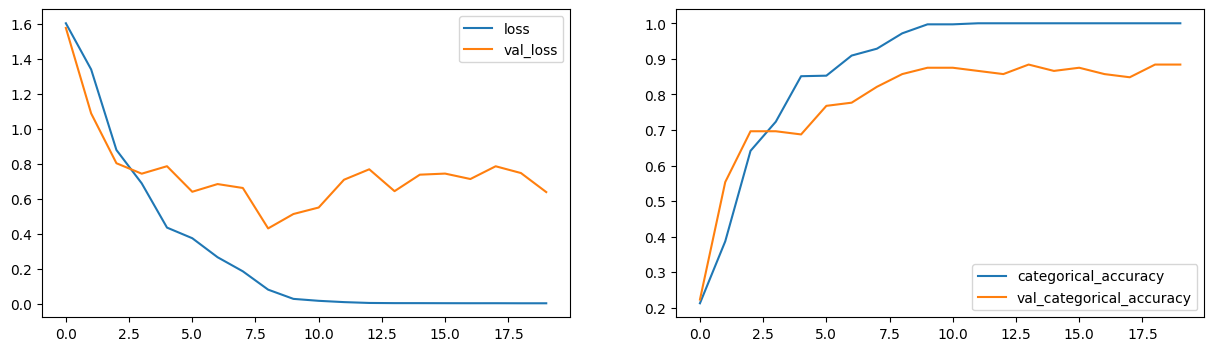

In [70]:
seqlen=30 
imgsize=120
batch_size=16
model=Conv3DModel(seqlen,imgsize,dropout=False,bn=False)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=False
                           )
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR]
                           )
plot(history)

###Result: Model is overfitting , lets add dropuout

### Experiment 4: Model with img_size 120 and seq_len=30 batch_size = 16 with Dropuout

batch_norm  False
batch_norm  False
batch_norm  False
batch_norm  False
bn  False
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 120, 120, 3)  0         
                             ]                                   
                                                                 
 Conv_1_0 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 Conv_1_pool (MaxPooling3D)  (None, 15, 60, 60, 8)     0         
                                                                 
 Conv_2_0 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 Conv_2_pool (MaxPooling3D)  (None, 7, 30, 30, 16)     0         
                                                                 
 Conv_3_0 (Conv3D)           (None, 7, 30,

C:\Users\sukum\AppData\Local\Temp\ipykernel_24040\685975519.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.6180 - categorical_accuracy: 0.2009Source path =  ./Project_data/val ; batch size = 16
6
6
42/42 [==============================] - 52s 1s/step - loss: 1.6180 - categorical_accuracy: 0.2009 - val_loss: 1.6045 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 51s 1s/step - loss: 1.5457 - categorical_accuracy: 0.2530 - val_loss: 1.3414 - val_categorical_accuracy: 0.3661 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - 54s 1s/step - loss: 1.2819 - categorical_accuracy: 0.4315 - val_loss: 1.0844 - val_categorical_accuracy: 0.5982 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - ETA: 0s - loss: 0.8590 - categorical_accuracy: 0.63396
6
42/42 [==============================] - 53s 1s/step - loss: 0.8590 - categorical_accuracy: 0.6339 - val_loss: 0.7092 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 5/20
42/42 [==========================

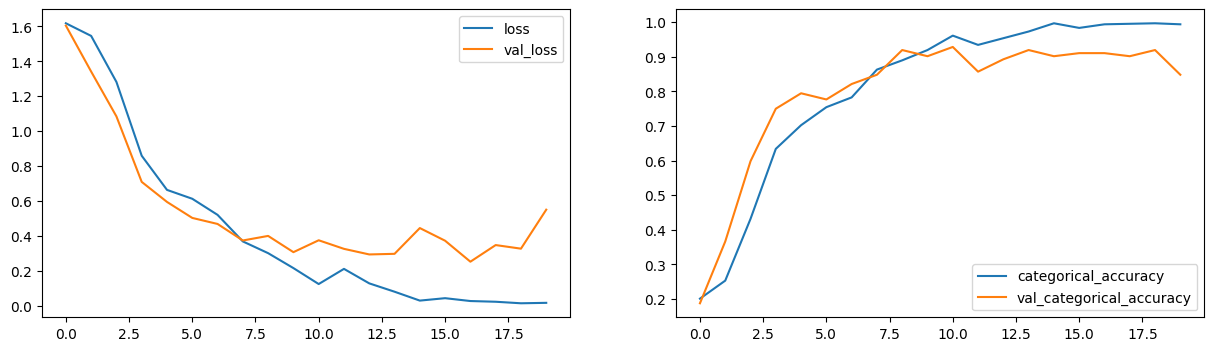

In [34]:
seqlen=30 
imgsize=120
batch_size=16
model=Conv3DModel(seqlen,imgsize,dropout=True,bn=False)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=False
                           )
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR]
                           )
plot(history)

###Result : Dropout improves overfitting a little. But model taking a lot of epoch to learn training data. Lets add batch normalization

### Experiment 5: Model with img_size 120 and seq_len=30 batch_size = 16 with Dropuout and Batch normalization for faster convergence

batch_norm  True
batch_norm  True
batch_norm  True
batch_norm  True
bn  True
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 120, 120, 3)  0         
                             ]                                   
                                                                 
 Conv_1_0 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_16 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 Conv_1_pool (MaxPooling3D)  (None, 15, 60, 60, 8)     0         
                                                                 
 Conv_2_0 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                               

C:\Users\sukum\AppData\Local\Temp\ipykernel_24040\1403775629.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 2.7236 - categorical_accuracy: 0.3408Source path =  ./Project_data/val ; batch size = 16
6
6
42/42 [==============================] - 53s 1s/step - loss: 2.7236 - categorical_accuracy: 0.3408 - val_loss: 2.1568 - val_categorical_accuracy: 0.2946 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 50s 1s/step - loss: 1.3185 - categorical_accuracy: 0.4792 - val_loss: 3.5675 - val_categorical_accuracy: 0.1964 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - 51s 1s/step - loss: 1.0467 - categorical_accuracy: 0.5848 - val_loss: 4.6968 - val_categorical_accuracy: 0.1964 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - ETA: 0s - loss: 0.8562 - categorical_accuracy: 0.66676
6
42/42 [==============================] - 51s 1s/step - loss: 0.8562 - categorical_accuracy: 0.6667 - val_loss: 4.7102 - val_categorical_accuracy: 0.2411 - lr: 5.0000e-04
Epoch 5/20
42/42 [======================

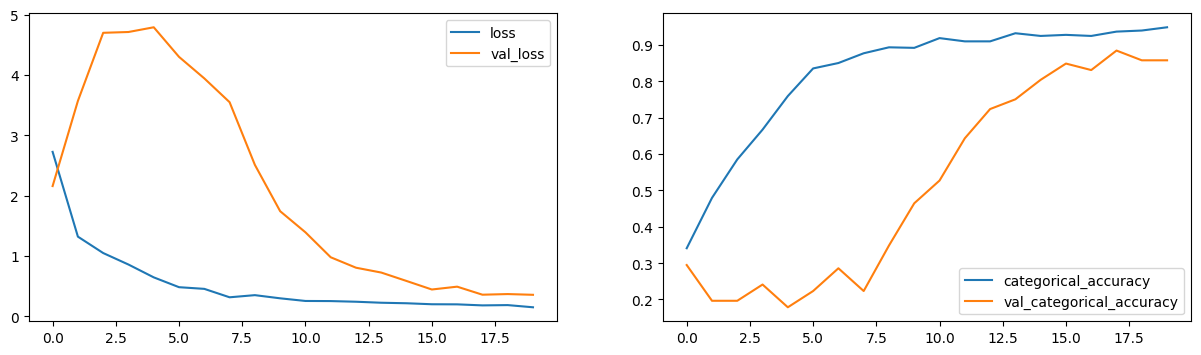

In [35]:
seqlen=30 
imgsize=120
batch_size=16
model=Conv3DModel(seqlen,imgsize,dropout=True,bn=True)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=False
                           )
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR]
                           )
plot(history)

### Observation: Training converges faster. But validation loss increase initially and then decrease. 
### Lets try data augmentation

### Experiment 6: Model with img_size 120 and seq_len=30 batch_size = 16 with Dropuout , Batch normalization  and data augmentation

batch_norm  True
batch_norm  True
batch_norm  True
batch_norm  True
bn  True
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 120, 120, 3)  0         
                             ]                                   
                                                                 
 Conv_1_0 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_20 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 Conv_1_pool (MaxPooling3D)  (None, 15, 60, 60, 8)     0         
                                                                 
 Conv_2_0 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                               

C:\Users\sukum\AppData\Local\Temp\ipykernel_24040\1261270122.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 2.6592 - categorical_accuracy: 0.2470Source path =  ./Project_data/val ; batch size = 16
6
6
42/42 [==============================] - 50s 1s/step - loss: 2.6592 - categorical_accuracy: 0.2470 - val_loss: 1.7135 - val_categorical_accuracy: 0.2232 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 49s 1s/step - loss: 1.5872 - categorical_accuracy: 0.3125 - val_loss: 2.2407 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - 49s 1s/step - loss: 1.4329 - categorical_accuracy: 0.3958 - val_loss: 3.5588 - val_categorical_accuracy: 0.1607 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - ETA: 0s - loss: 1.2260 - categorical_accuracy: 0.47476
6
42/42 [==============================] - 50s 1s/step - loss: 1.2260 - categorical_accuracy: 0.4747 - val_loss: 5.1545 - val_categorical_accuracy: 0.1964 - lr: 5.0000e-04
Epoch 5/20
42/42 [======================

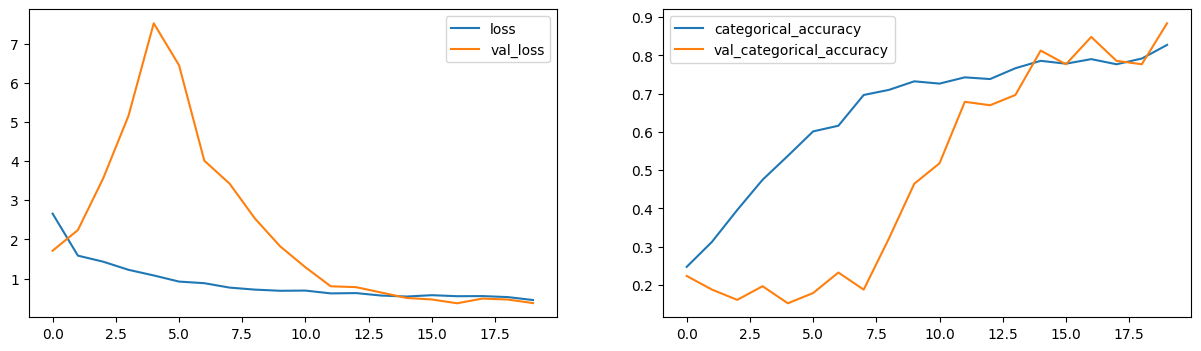

In [36]:
seqlen=30 
imgsize=120
batch_size=16
model=Conv3DModel(seqlen,imgsize,dropout=True,bn=True)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True
                           )
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR]
                           )
plot(history)

### Observation : Model looks less jittery and accuracy improved for validation data

### Experiment 7: Model with img_size 120 and seq_len=30 batch_size = 16 with Dropuout , Batch normalization  and data augmentation with 50 epochs

batch_norm  True
batch_norm  True
batch_norm  True
batch_norm  True
bn  True
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 120, 120, 3)  0         
                             ]                                   
                                                                 
 Conv_1_0 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_40 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 Conv_1_pool (MaxPooling3D)  (None, 15, 60, 60, 8)     0         
                                                                 
 Conv_2_0 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                               

C:\Users\sukum\AppData\Local\Temp\ipykernel_24040\3344374828.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1,


Epoch 1/50
42/42 [==============================] - 36s 842ms/step - loss: 2.7289 - categorical_accuracy: 0.2545 - val_loss: 1.5464 - val_categorical_accuracy: 0.2679 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 34s 835ms/step - loss: 1.5394 - categorical_accuracy: 0.3661 - val_loss: 1.7775 - val_categorical_accuracy: 0.2857 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 36s 871ms/step - loss: 1.5033 - categorical_accuracy: 0.3557 - val_loss: 3.5055 - val_categorical_accuracy: 0.1518 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 36s 871ms/step - loss: 1.3418 - categorical_accuracy: 0.4122 - val_loss: 4.2429 - val_categorical_accuracy: 0.2321 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 38s 912ms/step - loss: 1.3434 - categorical_accuracy: 0.4405 - val_loss: 4.0801 - val_categorical_accuracy: 0.2321 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 40s 961ms/step - loss: 1.2225 - categorical_accu

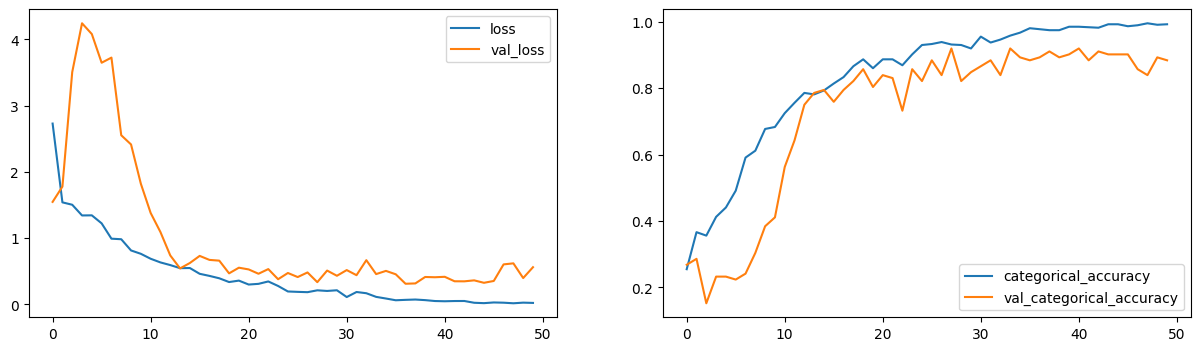

In [53]:
seqlen=30 
imgsize=120
batch_size=16
model=Conv3DModel(seqlen,imgsize,dropout=True,bn=True)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True
                           )
LR5 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001
)
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR5]
                           )
plot(history)

### Observation : Model became stable after 30 epochs, Less diffrence between training and validation loss

### Experiment 8: Model with img_size 120 and seq_len=30 batch_size = 16 with Dropuout , and data augmentation with 50 epochs

batch_norm  False
batch_norm  False
batch_norm  False
batch_norm  False
bn  False
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 120, 120, 3)  0         
                             ]                                   
                                                                 
 Conv_1_0 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 Conv_1_pool (MaxPooling3D)  (None, 15, 60, 60, 8)     0         
                                                                 
 Conv_2_0 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 Conv_2_pool (MaxPooling3D)  (None, 7, 30, 30, 16)     0         
                                                                 
 Conv_3_0 (Conv3D)           (None, 7, 30,

C:\Users\sukum\AppData\Local\Temp\ipykernel_24040\95954355.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1,


Epoch 1/50
42/42 [==============================] - 53s 1s/step - loss: 1.6186 - categorical_accuracy: 0.1860 - val_loss: 1.6012 - val_categorical_accuracy: 0.1964 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 54s 1s/step - loss: 1.5705 - categorical_accuracy: 0.2604 - val_loss: 1.5665 - val_categorical_accuracy: 0.3839 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 55s 1s/step - loss: 1.4629 - categorical_accuracy: 0.3452 - val_loss: 1.2266 - val_categorical_accuracy: 0.4196 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 53s 1s/step - loss: 1.2322 - categorical_accuracy: 0.4702 - val_loss: 1.0006 - val_categorical_accuracy: 0.5714 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 54s 1s/step - loss: 1.0267 - categorical_accuracy: 0.5551 - val_loss: 0.8165 - val_categorical_accuracy: 0.6250 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 52s 1s/step - loss: 0.8310 - categorical_accuracy: 0.6295 - val

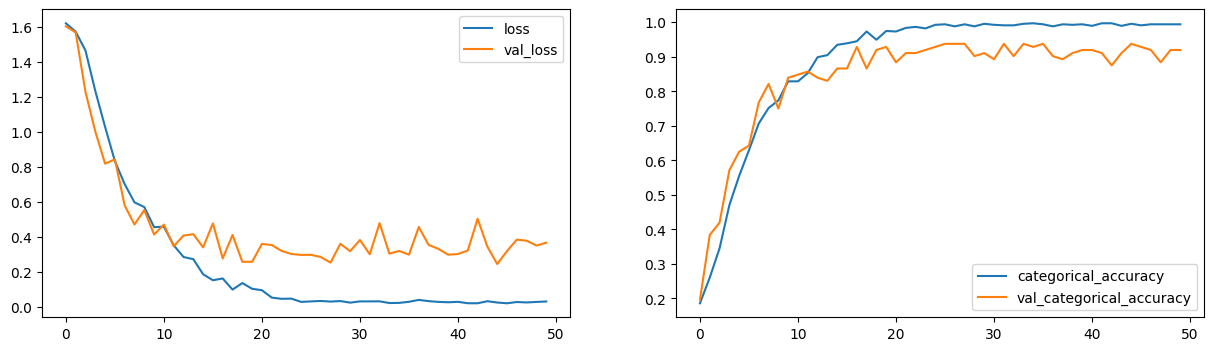

In [54]:
seqlen=30 
imgsize=120
batch_size=16
model=Conv3DModel(seqlen,imgsize,dropout=True,bn=False)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

LR5 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001
)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True
                           )
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR]
                           )
plot(history)

### Observation : Though finall accuracy is similar  without batch normalization, The diffrence between training and validation loss is comparatively mode

### Decission:
Prepare model with dropout, batchnormalization and data augmentation and save checkpoints for later inference

batch_norm  True
batch_norm  True
batch_norm  True
batch_norm  True
bn  True
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 120, 120, 3)  0         
                             ]                                   
                                                                 
 Conv_1_0 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_8 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 Conv_1_pool (MaxPooling3D)  (None, 15, 60, 60, 8)     0         
                                                                 
 Conv_2_0 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                

C:\Users\sukum\AppData\Local\Temp\ipykernel_36324\3451351384.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1,


Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 2.7725 - categorical_accuracy: 0.2857Source path =  ./Project_data/val ; batch size = 16

Epoch 1: saving model to model_init_2022-12-1414_48_50.530706\model-00001-2.77251-0.28571-1.59875-0.24107.h5
42/42 [==============================] - 124s 3s/step - loss: 2.7725 - categorical_accuracy: 0.2857 - val_loss: 1.5988 - val_categorical_accuracy: 0.2411 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.3527
Epoch 2: saving model to model_init_2022-12-1414_48_50.530706\model-00002-1.60921-0.35268-2.02562-0.25893.h5
42/42 [==============================] - 38s 923ms/step - loss: 1.6092 - categorical_accuracy: 0.3527 - val_loss: 2.0256 - val_categorical_accuracy: 0.2589 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.4505 - categorical_accuracy: 0.3616
Epoch 3: saving model to model_init_2022-12-1414_48_50.530706\model-00003-1.

42/42 [==============================] - ETA: 0s - loss: 0.1853 - categorical_accuracy: 0.9360
Epoch 22: saving model to model_init_2022-12-1414_48_50.530706\model-00022-0.18535-0.93601-0.17060-0.96429.h5
42/42 [==============================] - 47s 1s/step - loss: 0.1853 - categorical_accuracy: 0.9360 - val_loss: 0.1706 - val_categorical_accuracy: 0.9643 - lr: 2.5000e-04
Epoch 23/50
42/42 [==============================] - ETA: 0s - loss: 0.1831 - categorical_accuracy: 0.9301
Epoch 23: saving model to model_init_2022-12-1414_48_50.530706\model-00023-0.18308-0.93006-0.22215-0.91964.h5
42/42 [==============================] - 46s 1s/step - loss: 0.1831 - categorical_accuracy: 0.9301 - val_loss: 0.2221 - val_categorical_accuracy: 0.9196 - lr: 2.5000e-04
Epoch 24/50
42/42 [==============================] - ETA: 0s - loss: 0.1908 - categorical_accuracy: 0.9345
Epoch 24: saving model to model_init_2022-12-1414_48_50.530706\model-00024-0.19081-0.93452-0.20202-0.92857.h5
42/42 [==============

42/42 [==============================] - ETA: 0s - loss: 0.0290 - categorical_accuracy: 0.9896
Epoch 43: saving model to model_init_2022-12-1414_48_50.530706\model-00043-0.02902-0.98958-0.07243-0.98214.h5
42/42 [==============================] - 48s 1s/step - loss: 0.0290 - categorical_accuracy: 0.9896 - val_loss: 0.0724 - val_categorical_accuracy: 0.9821 - lr: 6.2500e-05
Epoch 44/50
42/42 [==============================] - ETA: 0s - loss: 0.0321 - categorical_accuracy: 0.9896
Epoch 44: saving model to model_init_2022-12-1414_48_50.530706\model-00044-0.03209-0.98958-0.06559-0.98214.h5
42/42 [==============================] - 48s 1s/step - loss: 0.0321 - categorical_accuracy: 0.9896 - val_loss: 0.0656 - val_categorical_accuracy: 0.9821 - lr: 6.2500e-05
Epoch 45/50
42/42 [==============================] - ETA: 0s - loss: 0.0373 - categorical_accuracy: 0.9881
Epoch 45: saving model to model_init_2022-12-1414_48_50.530706\model-00045-0.03729-0.98810-0.08989-0.96429.h5
42/42 [==============

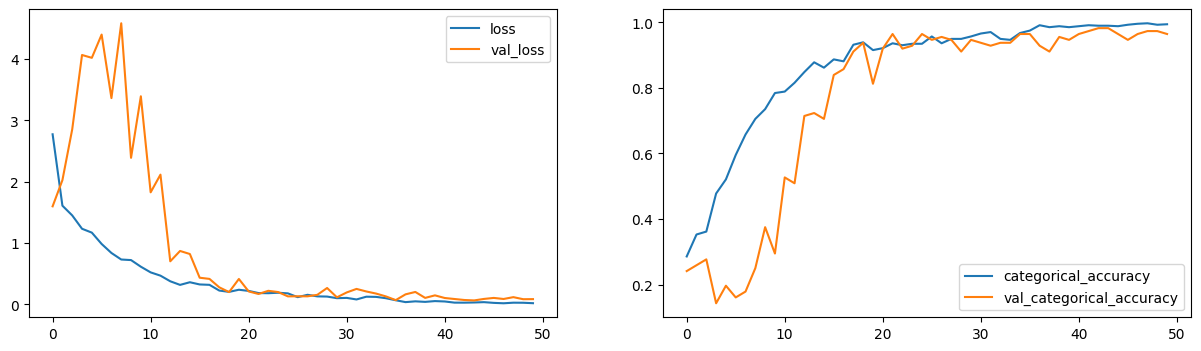

In [17]:
seqlen=30 
imgsize=120
batch_size=16
model=Conv3DModel(seqlen,imgsize,dropout=True,bn=True)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True
                           )
LR5 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001
)
val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR5,checkpoint]
                           )
plot(history)

### Sequence Model Experiments

In [18]:
def SequenceModel(frames=15,num_featuremaps = [16,32,64,128],num_denselayers = [64,32],num_classes = 5,dropout=False):
    
    # Input
    input_shape=(frames,120,120,3)

    model = Sequential()

    model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(Dense(num_denselayers[0], activation='relu'))
    model.add(Dense(num_denselayers[1], activation='relu'))
    if dropout == True:
        model.add(Dropout(0.25))

    ## using GRU as the RNN model
    model.add(GRU(64, return_sequences=False))
    if dropout == True:
        model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

### Experiment 9: Custom GRU model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_184 (TimeD  (None, 15, 60, 60, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_185 (TimeD  (None, 15, 60, 60, 16)   64        
 istributed)                                                     
                                                                 
 time_distributed_186 (TimeD  (None, 15, 30, 30, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_187 (TimeD  (None, 15, 30, 30, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_188 (TimeD  (None, 15, 30, 30, 32) 

C:\Users\sukum\AppData\Local\Temp\ipykernel_36324\3775027681.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Epoch 1/20
34/34 [==============================] - 22s 586ms/step - loss: 1.3235 - categorical_accuracy: 0.4691 - val_loss: 1.6734 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 20s 585ms/step - loss: 0.8808 - categorical_accuracy: 0.6956 - val_loss: 1.9284 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - 19s 579ms/step - loss: 0.6780 - categorical_accuracy: 0.7603 - val_loss: 1.7796 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 4/20
34/34 [==============================] - 20s 584ms/step - loss: 0.4993 - categorical_accuracy: 0.8309 - val_loss: 2.1349 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 5/20
34/34 [==============================] - 20s 586ms/step - loss: 0.3975 - categorical_accuracy: 0.8603 - val_loss: 2.4496 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 6/20
34/34 [==============================] - ETA: 0s - loss: 0.3463 - categorical_accuracy: 0

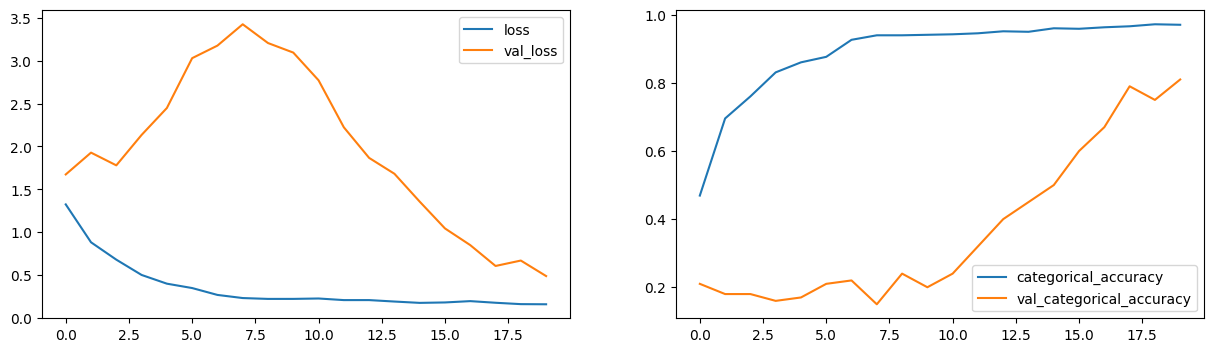

In [55]:
batch_size=20
seqlen=15
imgsize=120
model=SequenceModel(frames=seqlen)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True,batch_size=batch_size
                           )
LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)

val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize,batch_size=batch_size)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR_seq]
                           )
plot(history)

### Observation: 

### Experiment 10: Custom GRU model with Dropout

In [ ]:
batch_size=20
seqlen=30
imgsize=120
model=SequenceModel(frames=seqlen,dropout=True)
model.summary()
optimiser = optimizers.Adam(0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True
                           )
LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)

val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR_seq]
                           )
plot(history)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_197 (TimeD  (None, 30, 60, 60, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_198 (TimeD  (None, 30, 60, 60, 16)   64        
 istributed)                                                     
                                                                 
 time_distributed_199 (TimeD  (None, 30, 30, 30, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_200 (TimeD  (None, 30, 30, 30, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_201 (TimeD  (None, 30, 30, 30, 32) 

C:\Users\sukum\AppData\Local\Temp\ipykernel_36324\4120472165.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Epoch 1/20
34/34 [==============================] - 33s 949ms/step - loss: 1.5290 - categorical_accuracy: 0.3364 - val_loss: 1.6422 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 31s 920ms/step - loss: 1.3557 - categorical_accuracy: 0.4283 - val_loss: 1.8507 - val_categorical_accuracy: 0.1000 - lr: 0.0010
Epoch 3/20
 6/34 [====>.........................] - ETA: 20s - loss: 1.4015 - categorical_accuracy: 0.4167

### Observation: 

### Experiment 11. Custom GRU model with SGD optimizer

In [ ]:
batch_size=20
seqlen=15
imgsize=120
model=SequenceModel(dropout=True)
model.summary()
optimiser = "sgd"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True
                           )
LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)

val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR_seq]
                           )
plot(history)

### Observation: 

### Transfering Learning Experiments

In [ ]:
def SequenceModelTLM(frames=15,num_classes = 5,imgsize=120,dropout=False, lstm=False):
    
    # Input
    input_shape=(frames,imgsize,imgsize,3)
    # Define model
    mobile_model = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    
    
    model.add(TimeDistributed(mobile_model,input_shape=input_shape))
   
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    if lstm==False:
        model.add(GRU(64, return_sequences=False))
    else :
        model.add(LSTM(64, return_sequences=False))
    if dropout == True:
        model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    if dropout == True:
        model.add(Dropout(0.25))


    # using Softmax as last layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

### Experiment 12: Transfer learning with mobilenet and GRU batchs size =16 and seqlen =30

In [ ]:
batch_size=16
seqlen=30
imgsize=120
model=SequenceModelTLM(frames=seqlen,imgsize=imgsize,dropout=True,lstm=False)
model.summary()
optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True,batch_size=batch_size,
                           )
#LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)
LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1,mode='auto',min_delta=0.0001)

val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize,batch_size=batch_size)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR_seq]
                           )
plot(history)

### Observation: 

### Experiment 13: Transfer learning with mobilenet and GRU batchs size =8 and seqlen =30

In [ ]:
batch_size=8
seqlen=30
imgsize=120
model=SequenceModelTLM(frames=seqlen,imgsize=imgsize,dropout=True,lstm=False)
model.summary()
optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True,batch_size=batch_size,
                           )
#LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)
LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1,mode='auto',min_delta=0.0001)

val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize,batch_size=batch_size)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR_seq]
                           )
plot(history)

### Observation: 

### Experiment 14: Transfer learning with mobilenet and GRU batch size =8 and seqlen =15

In [ ]:
batch_size=8
seqlen=15
imgsize=120
model=SequenceModelTLM(frames=seqlen,imgsize=imgsize,dropout=True,lstm=False)
model.summary()
optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True,batch_size=batch_size,
                           )
#LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)
LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1,mode='auto',min_delta=0.0001)

val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize,batch_size=batch_size)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR_seq]
                           )
plot(history)

### Observation: 

### Experiment 15: Transfer learning with mobilenet and LSTM

In [ ]:
batch_size=8
seqlen=15
imgsize=120
model=SequenceModelTLM(frames=seqlen,imgsize=imgsize,dropout=True,lstm=True)
model.summary()
optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

steps_per_epoch,validation_steps=get_train_validation_steps(num_train_sequences,batch_size)

train_generator = generator_cv(train_path, train_doc,seq_len=seqlen,img_size=imgsize,aug=True,batch_size=batch_size,
                           )
#LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001)
LR_seq = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1,mode='auto',min_delta=0.0001)

val_generator = generator_cv(val_path, val_doc,seq_len=seqlen,img_size=imgsize,batch_size=batch_size)
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0
                      ,callbacks=[LR_seq]
                           )
plot(history)

### Observation: 